In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
from torchvision import datasets, transforms
from scipy.stats import entropy


from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


#import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
logged_in = False

Using device: cpu


In [2]:
FOLDER_PATH = '/content/drive/MyDrive/Deep Learning/ex3_305673212_312349509/FashionMNIST'
if (os.path.exists(FOLDER_PATH)):
  _PATH = FOLDER_PATH
else:
  _PATH = "data" #for git runs

In [3]:
#hyper parameters
#TODO: the WGAN paper states lr= 5e-5, should we use it?
DIM = 64 # Model dimensionality
BATCH_SIZE = 50 # Batch size
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
GEN_ITERS = 200000 # How many generator iterations to train for
LATENT_DIM = 128
in_channels = 1
input_img_w = 28 #FashionMNIST Width
input_img_h = 28 #FashionMNIST Hight
OUTPUT_DIM = input_img_w*input_img_h # Number of pixels in MNIST (28*28)
CIFAR_SIZE = (32,32)


# W&B





In [4]:
#TODO: remove before submission
import wandb

if not logged_in:
    try:
        from mycreds import WANDB_API_KEY
        logged_in = wandb.login(key=WANDB_API_KEY)

    except ImportError:
        raise ImportError ("hi! its Nadav 😅\nprovide your WANDB_API_KEY in mycreds.py 🙏:\n"
              "1. Create a free account at https://wandb.ai/site 🔥\n"
              "2. copy your API key from https://wandb.ai/authorize\n"
              "3. create a file named mycreds.py in the same directory as this notebook\n"
              "4. add the following line to mycreds.py: WANDB_API_KEY = 'your API key'")

wandb: Currently logged in as: nadavo11 (nadavoteam). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nadav\_netrc


# Data Preprocessing
## Data loaders
let's prepare our data by loading it, normalizing it, and creating the data loaders.

In [5]:
""
# Define the transform to convert the images to tensors and normalize them and resize them to 32X32 to match CIFAR input

transform = transforms.Compose([
    transforms.Resize(CIFAR_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Download and load the training data
train_dataset = datasets.FashionMNIST(root=_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=_PATH, train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_loader)

## Visualize the data

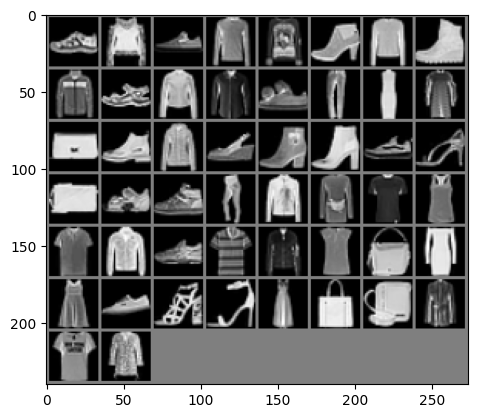

In [6]:
import torchvision


# Display some of the images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_grid(images):
    imshow(torchvision.utils.make_grid(images))

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_grid(images)

# Network Architecture
We will implemnet gernerator and descriminator/critic as defined in "Improved Training of Wasserstein GANs" papaer for CIFAR10We decided to resize the FashionMNIST images from 28X28X1 to 32X32X1 to be able to use same conv layers used in the paper



# generator

### conv dimensions
convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding


In [18]:

#Input to Generator is noise which can be random or not, nosie dimention is 128

class Generator(nn.Module):

    def __init__(self,
                 dim=DIM,
                 latent_dim = LATENT_DIM):

        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim

        # 1. Fully connected:
        # 128 -> 4*4*4*dim
        self.linear = nn.Linear(latent_dim,
                                4*4*4*dim)

        self.bn1 = nn.BatchNorm1d(4*4*4*dim)

        # 2. deConv
        # (4x4) 4dim -> (8x8) 2dim
        self.deconv2 = nn.ConvTranspose2d(4*dim,
                                          2*dim,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)
        self.bn2 = nn.BatchNorm2d(2*dim)

        # 3. deConv
        # (8x8) 2dim -> (16x16) dim
        self.deconv3 = nn.ConvTranspose2d(2*dim,
                                          dim,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)
        self.bn3 = nn.BatchNorm2d(dim)

        # 4. deConv
        #(16x16) dim -> (32X32) 1
        self.deconv4 = nn.ConvTranspose2d(dim,
                                          in_channels,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)


    # TODO : complete forward function
    #  check if we need to add noise to the forward function
    def forward(self, n_samples, noise=None):
        if noise is None:
            noise = torch.randn(n_samples, self.latent_dim).to(device)

        # 1. Fully connected
        x = self.linear(noise)
        x = self.bn1(x)
        x = F.relu(x)
        x = x.view(-1, 4*self.dim, 4, 4)

        # 2.Deconv
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        # 3. Deconv
        x = self.deconv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # 4. Deconv
        x = self.deconv4(x)
        x = torch.tanh(x)

        return x






 # Discriminator

convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding

In [19]:
class Discriminator(nn.Module):
    def __init__(self,
                dim = DIM,
                in_channels = 1):

        super(Discriminator, self).__init__()
        self.in_features = in_channels
        self.dim=dim
        self.conv1 = nn.Conv2d(kernel_size=5,
                             in_channels=in_channels,
                             out_channels=self.dim,
                             stride=2,) # dimX14X4

        self.conv2 = nn.Conv2d(kernel_size=5,
                                in_channels=self.dim,
                                out_channels=2*self.dim,
                                stride=2,) # 2dimX5X5
        self.batch_norm2 = nn.BatchNorm2d(2*self.dim)

        self.conv3 = nn.Conv2d(kernel_size=1,
                                in_channels=2*self.dim,
                                out_channels=4*self.dim,
                                stride=1,) # 4dimX5X5
        self.batch_norm3 = nn.BatchNorm2d(4*self.dim)

        self.fc = nn.Linear(4*5*5*self.dim, 1)
    #     self.apply(self._weights_init)
    #
    # def _weights_init(self, m):
    #     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    #         nn.init.kaiming_normal_(m.weight, a=0.2, nonlinearity='leaky_relu')
    #         if m.bias is not None:
    #             nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = x.view(-1, 4*5*5*self.dim)  # Flatten
        x = self.fc(x)
        return x


In [20]:
class GAN(nn.Module):
    def __init__(self,
                 dim=DIM,
                 mode='wgan',
                 latent_dim=LATENT_DIM,
                 ):
        super(GAN, self).__init__()
        self.generator = Generator(dim = dim,
                                   mode = mode,
                                   latent_dim= latent_dim)
        self.discriminator = Discriminator(dim = dim,
                                           mode = mode,in_channels=in_channels)


# Evaluation
we define our evaluation metric as the inception score:

In [21]:
# Inception score (Evaluation)
def inception_score(images, batch_size=32, splits=10):
    # Load pre-trained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    
    def get_pred(x):
        with torch.no_grad():
            # Upsample images as InceptionV3 requires min 299x299
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
            # InceptionV3 needs input shape of N x 3 x 299 x 299
            x = x.repeat(1, 3, 1, 1)
            x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()
    
    # Resize images to 299x299 as required by InceptionV3
    images = [TF.resize(img, (299, 299)) for img in images]
    images = torch.stack(images)
    
    # Calculate predictions
    preds = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        preds.append(get_pred(batch))
    preds = np.concatenate(preds, axis=0)
    
    # Calculate Inception Score
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

def disc_cost (mode,disc_fake,disc_real):
    return (torch.mean(disc_fake) - torch.mean(disc_real) if mode == 'wgan' else
                            (F.binary_cross_entropy_with_logits(disc_fake, torch.zeros_like(disc_fake)) +
                                F.binary_cross_entropy_with_logits(disc_real, torch.ones_like(disc_real))) / 2.)

def gen_cost(disc_fake,mode):
    return (-torch.mean(disc_fake) if mode == 'wgan' else F.binary_cross_entropy_with_logits(disc_fake, torch.ones_like(disc_fake)))

#### Test the generator
can be removed before submission

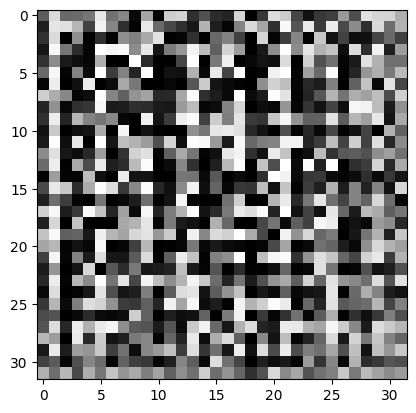

In [22]:
generator = Generator()
img = generator.forward(15)


plt.imshow(img[0].transpose(0,2).detach().numpy(), cmap='gray')
plt.show()

# Test the discriminator

In [23]:
disc = Discriminator()
output = disc.forward(img)
print(output)


tensor([[-0.0674],
        [ 0.1865],
        [-0.4163],
        [ 0.6360],
        [-0.3846],
        [-0.5412],
        [-0.4318],
        [-0.7397],
        [-0.5282],
        [-0.5701],
        [-0.5564],
        [-0.5839],
        [-0.7611],
        [-0.5003],
        [-0.0430]], grad_fn=<AddmmBackward0>)


#Lost Function/ Inception

In [24]:
def clip_weights(net, clip_value):
    for p in net.parameters():
        p.data.clamp_(-clip_value, clip_value)

In [27]:

class GAN:
    def __init__(self, generator, discriminator, mode, train_loader, val_loader, gen_iters, critic_iters, batch_size = BATCH_SIZE):
        self.generator = generator 
        self.discriminator = discriminator 
        self.mode = mode
        self.gen_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
        self.disc_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.gen_iters =gen_iters
        self.critic_iters = critic_iters
        self.batch_size = batch_size

    # NADAV/REUT: Do we need to defrenciate the optimizers?
 #   self.setup_optimizers()

    #def setup_optimizers(self):
    #     if self.mode == 'wgan':
    #         self.gen_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
    #         self.disc_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)
    #     elif self.mode == 'dcgan':
    #         self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    #         self.disc_optimizer = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

  #TODO: Consider change it if training is too heavey 
    def inf_train_gen(self):
        while True:
            for images, _ in self.train_loader:
                yield images


    def train(self):
        # Define a clipping value (e.g., 0.01)
        clipping_value = 0.01

        # wandb
        wandb.init(
            # set the wandb project where this run will be logged
            project="GANs",
            # track hyperparameters and run metadata
            config={
                f"learning_rate": 5e-5,
                f"architecture": "VAE",
                f"dataset": "Fashion MNIST",
                })
        # Watch the model to log gradients and parameters
        wandb.watch(self.generator, log="all", log_freq=100)
        wandb.watch(self.discriminator, log="all", log_freq=100)

        for iteration in range(self.gen_iters):
            start_time = time.time()
            # Train generator
            self.generator.train()
            self.gen_optimizer.zero_grad()
            fake_data = self.generator(self.batch_size)
            disc_fake = self.discriminator(fake_data)
            gen_cost_val = gen_cost(mode=self.mode,disc_fake=disc_fake )
            gen_cost_val.backward()
            self.gen_optimizer.step()

            # Train critic/dicriminator
            disc_iters = 1 if self.mode == 'dcgan' else self.critic_iters
            for _ in range(disc_iters):
                _data = next(self.inf_train_gen()).to(device)
                self.discriminator.train()
                self.disc_optimizer.zero_grad()


                disc_real = self.discriminator(_data)

                # forward pass
                fake_data = self.generator(self.batch_size)
                disc_fake = self.discriminator(fake_data)

                #loss
                disc_cost_val =disc_cost(mode=self.mode,disc_real=disc_real,disc_fake=disc_fake)
                #backprop
                disc_cost_val.backward()
                # grad clipping
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)
                self.disc_optimizer.step()

                # Apply weight clipping for WGAN
                if self.mode == 'wgan':
                    clip_weights(self.discriminator, clipping_value)
                        
            print(f"Iteration {iteration}, Generator Cost: {gen_cost_val}, Discriminator Cost: {disc_cost_val} Time: {time.time() - start_time}")
            wandb.log({"Generator Cost": gen_cost_val, "Discriminator Cost": disc_cost_val}, step=iteration)

            # Logging

            # Calculate inception score every 1K iters
            if iteration % 1000 == 999:
                with torch.no_grad():
                    # z = torch.randn(1000, 100, 1, 1).to(device) this will break the code because it doesn't match the generator latent dimension
                    generated_imgs = generator(1000)
                    generated_imgs = generated_imgs.cpu()
                    inception_mean, inception_std = inception_score(generated_imgs)
                    print(f"Genrator Iteration {iteration}: Inception Score: {inception_mean} ± {inception_std}")
                    wandb.log({"Inception Score": inception_mean}, step=iteration)

                    img = generator.forward(10)
                    plt.imshow(img[0].transpose(0,2).detach().numpy(), cmap='gray')
                    plt.show()

            # Calculate val loss of the discriminator and generate samples every 100 iters
            if iteration % 100 == 99:
                ###################
                img = generator.forward(10)
                plt.imshow(img[0].transpose(0,2).detach().numpy(), cmap='gray')
                plt.show()
                ###################
                val_disc_costs = []
                for images, _ in self.val_loader:
                    # images = torch.tensor(images).float()  # Convert images to a PyTorch tensor
                    fake_data = self.generator(self.batch_size)
                    disc_fake = self.discriminator(fake_data)
                    _dev_disc_cost = disc_cost(mode=self.mode,disc_real=images,disc_fake=disc_fake)  # Compute the discriminator cost
                    val_disc_costs.append(_dev_disc_cost.item())  # Append the cost to the list
                    wandb.log({"Validation Discriminator Cost": _dev_disc_cost}, step=iteration)



            # mean_dev_disc_cost = np.mean(val_disc_costs) #TODO plot

    
                







Discriminator Cost,█▇▆▆▆▅▅▅▅▅▄▄▄▃▃▄▇▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁
Generator Cost,▁▃▄▄▅▅▄▅▅▅▅▆▆▆▆▆▁▅▆▇▇▇▇▇▇▇██████████▇█▇█
Validation Discriminator Cost,▁
Discriminator Cost,-0.59418
Generator Cost,0.39904
Validation Discriminator Cost,0.01356


Iteration 0, Generator Cost: -0.35044872760772705, Discriminator Cost: -0.016972534358501434 Time: 0.5430047512054443
Iteration 1, Generator Cost: 0.02511054463684559, Discriminator Cost: -0.040959469974040985 Time: 0.519089937210083
Iteration 2, Generator Cost: 0.042761705815792084, Discriminator Cost: -0.06604981422424316 Time: 0.5174839496612549
Iteration 3, Generator Cost: 0.06147091090679169, Discriminator Cost: -0.09428657591342926 Time: 0.5175662040710449
Iteration 4, Generator Cost: 0.08045908808708191, Discriminator Cost: -0.11757977306842804 Time: 0.49370718002319336
Iteration 5, Generator Cost: 0.09926452487707138, Discriminator Cost: -0.1445261538028717 Time: 0.46515655517578125
Iteration 6, Generator Cost: 0.1148991659283638, Discriminator Cost: -0.16164669394493103 Time: 0.4938075542449951
Iteration 7, Generator Cost: 0.12791062891483307, Discriminator Cost: -0.1765858381986618 Time: 0.49727320671081543
Iteration 8, Generator Cost: 0.1353098750114441, Discriminator Cost: 

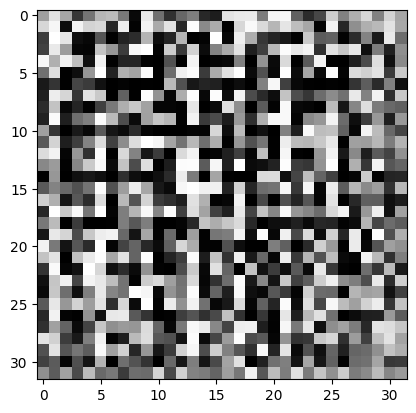

Iteration 100, Generator Cost: 0.407857745885849, Discriminator Cost: -0.5651083588600159 Time: 0.6197102069854736
Iteration 101, Generator Cost: 0.40494975447654724, Discriminator Cost: -0.5851349830627441 Time: 0.6134657859802246
Iteration 102, Generator Cost: 0.4135504961013794, Discriminator Cost: -0.5847752094268799 Time: 0.6562302112579346
Iteration 103, Generator Cost: 0.4179600477218628, Discriminator Cost: -0.5768903493881226 Time: 0.6983194351196289
Iteration 104, Generator Cost: 0.4162437319755554, Discriminator Cost: -0.5874782800674438 Time: 0.7143697738647461
Iteration 105, Generator Cost: 0.40726330876350403, Discriminator Cost: -0.4995012581348419 Time: 0.6690456867218018
Iteration 106, Generator Cost: 0.3564993143081665, Discriminator Cost: 0.033535465598106384 Time: 0.6522071361541748
Iteration 107, Generator Cost: -0.17964385449886322, Discriminator Cost: -0.09415280073881149 Time: 0.6622602939605713
Iteration 108, Generator Cost: -0.07649929821491241, Discriminator 

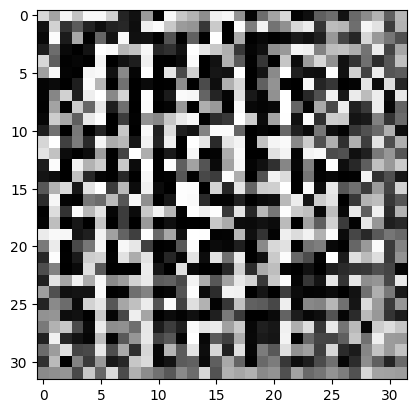

Iteration 200, Generator Cost: 0.2939712107181549, Discriminator Cost: -0.49790138006210327 Time: 0.6657266616821289
Iteration 201, Generator Cost: 0.29748183488845825, Discriminator Cost: -0.5359189510345459 Time: 0.637115478515625
Iteration 202, Generator Cost: 0.3374207615852356, Discriminator Cost: -0.5592197179794312 Time: 0.7176542282104492
Iteration 203, Generator Cost: 0.38210001587867737, Discriminator Cost: -0.632266104221344 Time: 0.6171567440032959
Iteration 204, Generator Cost: 0.4283562898635864, Discriminator Cost: -0.6448425054550171 Time: 0.6666676998138428
Iteration 205, Generator Cost: 0.45282337069511414, Discriminator Cost: -0.6662632822990417 Time: 0.6716709136962891
Iteration 206, Generator Cost: 0.4594852328300476, Discriminator Cost: -0.6811472177505493 Time: 0.7092258930206299
Iteration 207, Generator Cost: 0.46289509534835815, Discriminator Cost: -0.6825153231620789 Time: 0.6739473342895508
Iteration 208, Generator Cost: 0.4660477936267853, Discriminator Cost

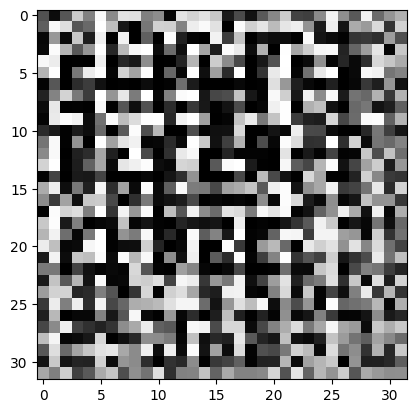

Iteration 300, Generator Cost: 0.0283798985183239, Discriminator Cost: -0.26395002007484436 Time: 1.0021862983703613
Iteration 301, Generator Cost: 0.029339788481593132, Discriminator Cost: -0.27583470940589905 Time: 0.7708175182342529
Iteration 302, Generator Cost: 0.031412769109010696, Discriminator Cost: -0.28710901737213135 Time: 0.8209023475646973
Iteration 303, Generator Cost: 0.03149404004216194, Discriminator Cost: -0.2867426574230194 Time: 0.9121968746185303
Iteration 304, Generator Cost: 0.03278740495443344, Discriminator Cost: -0.27423495054244995 Time: 0.8451495170593262
Iteration 305, Generator Cost: 0.032855600118637085, Discriminator Cost: -0.28449124097824097 Time: 0.8915908336639404
Iteration 306, Generator Cost: 0.0331067331135273, Discriminator Cost: -0.29350027441978455 Time: 0.7691154479980469
Iteration 307, Generator Cost: 0.033652789890766144, Discriminator Cost: -0.29148417711257935 Time: 0.7911972999572754
Iteration 308, Generator Cost: 0.032457612454891205, Di

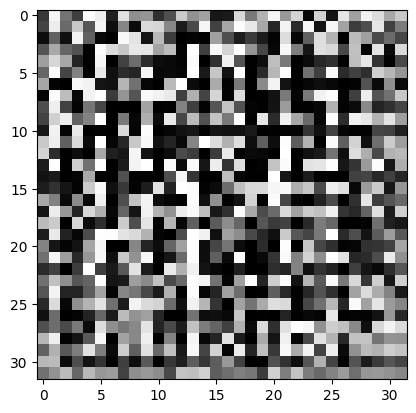

Iteration 400, Generator Cost: 0.02936268039047718, Discriminator Cost: -0.4156495928764343 Time: 0.7423419952392578
Iteration 401, Generator Cost: 0.02991301938891411, Discriminator Cost: -0.4099045395851135 Time: 0.8068804740905762
Iteration 402, Generator Cost: 0.029315784573554993, Discriminator Cost: -0.3968835473060608 Time: 0.7781033515930176
Iteration 403, Generator Cost: 0.03074469044804573, Discriminator Cost: -0.40377211570739746 Time: 0.7241270542144775
Iteration 404, Generator Cost: 0.030136335641145706, Discriminator Cost: -0.3846546411514282 Time: 0.7239501476287842
Iteration 405, Generator Cost: 0.030745239928364754, Discriminator Cost: -0.41799214482307434 Time: 0.7303733825683594
Iteration 406, Generator Cost: 0.03055049479007721, Discriminator Cost: -0.41400495171546936 Time: 0.8019921779632568
Iteration 407, Generator Cost: 0.030623087659478188, Discriminator Cost: -0.40290147066116333 Time: 0.8498120307922363
Iteration 408, Generator Cost: 0.03190738707780838, Disc

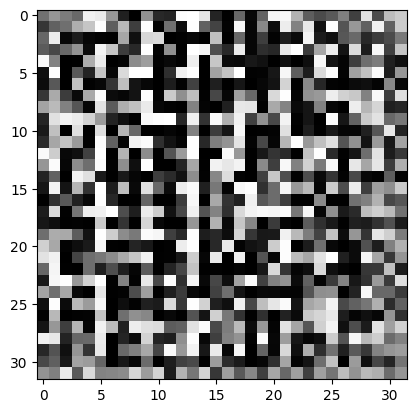

Iteration 500, Generator Cost: 0.02668824978172779, Discriminator Cost: -0.4366312026977539 Time: 0.7288424968719482
Iteration 501, Generator Cost: 0.027341896668076515, Discriminator Cost: -0.4143114387989044 Time: 0.7100348472595215
Iteration 502, Generator Cost: 0.027089819312095642, Discriminator Cost: -0.4216296970844269 Time: 0.6815154552459717
Iteration 503, Generator Cost: 0.026828737929463387, Discriminator Cost: -0.4221735894680023 Time: 0.6714777946472168
Iteration 504, Generator Cost: 0.027191948145627975, Discriminator Cost: -0.41106557846069336 Time: 0.7266805171966553
Iteration 505, Generator Cost: 0.02711542136967182, Discriminator Cost: -0.4254727065563202 Time: 0.7829551696777344
Iteration 506, Generator Cost: 0.027135372161865234, Discriminator Cost: -0.41272926330566406 Time: 0.7285304069519043
Iteration 507, Generator Cost: 0.02687179483473301, Discriminator Cost: -0.4347189664840698 Time: 0.6645584106445312
Iteration 508, Generator Cost: 0.02745906077325344, Discr

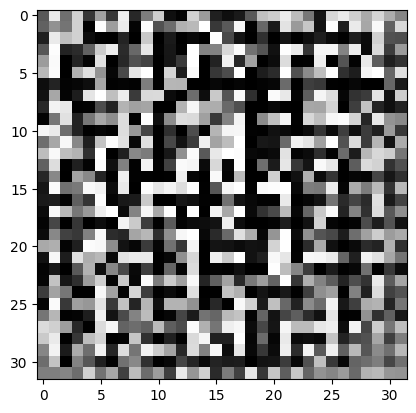

Iteration 600, Generator Cost: 0.02621937356889248, Discriminator Cost: -0.4220674932003021 Time: 1.404515027999878
Iteration 601, Generator Cost: 0.02651132270693779, Discriminator Cost: -0.43702855706214905 Time: 1.4732253551483154
Iteration 602, Generator Cost: 0.026800742372870445, Discriminator Cost: -0.4221123456954956 Time: 1.3498115539550781
Iteration 603, Generator Cost: 0.026339950039982796, Discriminator Cost: -0.4383402466773987 Time: 1.4449026584625244
Iteration 604, Generator Cost: 0.027120307087898254, Discriminator Cost: -0.4396500587463379 Time: 1.8080785274505615
Iteration 605, Generator Cost: 0.02662048488855362, Discriminator Cost: -0.4394994378089905 Time: 1.3191611766815186
Iteration 606, Generator Cost: 0.026739291846752167, Discriminator Cost: -0.4167765974998474 Time: 1.5429565906524658
Iteration 607, Generator Cost: 0.026627328246831894, Discriminator Cost: -0.440690815448761 Time: 1.154559850692749
Iteration 608, Generator Cost: 0.02659771591424942, Discrimin

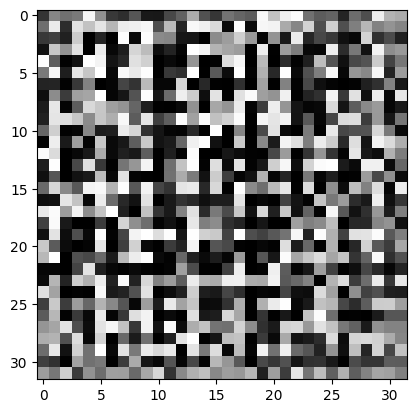

Iteration 700, Generator Cost: 0.026843471452593803, Discriminator Cost: -0.44315680861473083 Time: 1.6105127334594727
Iteration 701, Generator Cost: 0.026597438380122185, Discriminator Cost: -0.3920525908470154 Time: 1.8051261901855469
Iteration 702, Generator Cost: 0.026523618027567863, Discriminator Cost: -0.4420538544654846 Time: 1.5106468200683594
Iteration 703, Generator Cost: 0.026361141353845596, Discriminator Cost: -0.4407222867012024 Time: 2.033508062362671
Iteration 704, Generator Cost: 0.02679283544421196, Discriminator Cost: -0.4560820162296295 Time: 2.5160505771636963
Iteration 705, Generator Cost: 0.026771824806928635, Discriminator Cost: -0.4256432354450226 Time: 1.4136435985565186
Iteration 706, Generator Cost: 0.026830187067389488, Discriminator Cost: -0.4406242370605469 Time: 2.15105938911438
Iteration 707, Generator Cost: 0.026673510670661926, Discriminator Cost: -0.4347245395183563 Time: 1.5821552276611328
Iteration 708, Generator Cost: 0.02662714198231697, Discrim

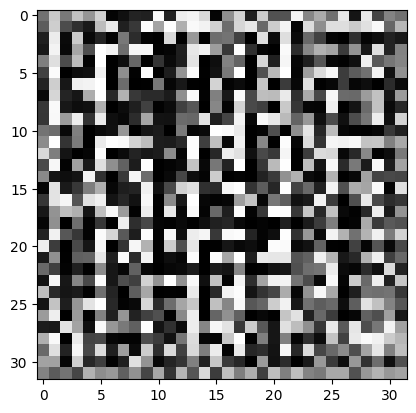

Iteration 800, Generator Cost: 0.026176076382398605, Discriminator Cost: -0.457001268863678 Time: 0.8057739734649658
Iteration 801, Generator Cost: 0.02643844299018383, Discriminator Cost: -0.434858113527298 Time: 1.0618207454681396
Iteration 802, Generator Cost: 0.02709249034523964, Discriminator Cost: -0.4477529525756836 Time: 1.1952283382415771
Iteration 803, Generator Cost: 0.026669718325138092, Discriminator Cost: -0.4555209279060364 Time: 0.7582190036773682
Iteration 804, Generator Cost: 0.0263009425252676, Discriminator Cost: -0.43411773443222046 Time: 0.7546489238739014
Iteration 805, Generator Cost: 0.026481211185455322, Discriminator Cost: -0.4304381310939789 Time: 0.9954783916473389
Iteration 806, Generator Cost: 0.026880042627453804, Discriminator Cost: -0.44898879528045654 Time: 1.1275193691253662
Iteration 807, Generator Cost: 0.026981739327311516, Discriminator Cost: -0.44380348920822144 Time: 0.7229995727539062
Iteration 808, Generator Cost: 0.026930658146739006, Discri

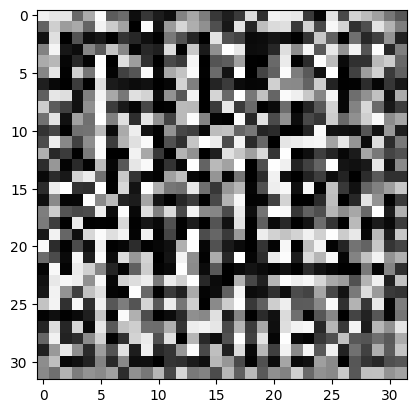

Iteration 900, Generator Cost: 0.026885736733675003, Discriminator Cost: -0.4175594449043274 Time: 0.605144739151001
Iteration 901, Generator Cost: 0.02664094977080822, Discriminator Cost: -0.44629472494125366 Time: 0.546489953994751
Iteration 902, Generator Cost: 0.02658548578619957, Discriminator Cost: -0.4408038258552551 Time: 0.6244628429412842
Iteration 903, Generator Cost: 0.026348287239670753, Discriminator Cost: -0.43648168444633484 Time: 0.6640026569366455
Iteration 904, Generator Cost: 0.026865476742386818, Discriminator Cost: -0.4474022686481476 Time: 0.6875624656677246
Iteration 905, Generator Cost: 0.026808151975274086, Discriminator Cost: -0.45846742391586304 Time: 0.7257273197174072
Iteration 906, Generator Cost: 0.026621658354997635, Discriminator Cost: -0.4373340904712677 Time: 0.6027917861938477
Iteration 907, Generator Cost: 0.02645448036491871, Discriminator Cost: -0.4275682866573334 Time: 0.6949253082275391
Iteration 908, Generator Cost: 0.026766106486320496, Discr

C:\Users\nadav\anaconda3\envs\DCGAN-and-WGAN1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nadav\anaconda3\envs\DCGAN-and-WGAN1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
dc_gen=Generator(dim = DIM,latent_dim= LATENT_DIM)
dc_disc = Discriminator(dim = DIM,in_channels=in_channels)
dcgan = GAN(mode = 'wgan'
            , train_loader=train_loader
            , gen_iters = GEN_ITERS
            , critic_iters=CRITIC_ITERS
            ,batch_size = BATCH_SIZE
            ,discriminator = dc_disc
            ,generator = dc_gen
            ,val_loader=test_loader)
dcgan.train()

TEST THE 1000th iteration
can be remooved

In [ ]:
with torch.no_grad():
    generated_imgs = generator(10)
    generated_imgs = generated_imgs.cpu()
    inception_mean, inception_std = inception_score(generated_imgs)
    print(f"Genrator Iteration {1000}: Inception Score: {inception_mean} ± {inception_std}")
    img = generator.forward(10)
    plt.imshow(img[0].transpose(0,2).detach().numpy(), cmap='gray')
    plt.show()